In [ ]:
#   ___                  _                
#  / _/______ ____  ____(_)__ _______     
# / _/ __/ _ `/ _ \/ __/ (_-</ __/ _ \    
#/_//_/  \_,_/_//_/\__/_/___/\__/\___/    
# ___ _____(_)__ ___ ____  / /_(_)       
# / _ `/ __/ (_-</ _ `/ _ \/ __/ /        
# \_, /_/ /_/___/\_,_/_//_/\__/_/         
#/___/
#
#Samee Lab @ Baylor College Of Medicine
#francisco.grisanticanozo@bcm.edu

In [46]:
import pandas as pd
import scipy as sp
import numpy as np
import pprint
from pathlib import Path
import os
import sys
#from tqdm.notebook import trange, tqdm

#Plotting lib
from matplotlib import pyplot as plt
import seaborn as sb
%matplotlib inline
plt.style.use('ggplot')

#Specific lib
import scanpy as sc
import anndata
import warnings
import logging
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.base import RegressorMixin
from sklearn.base import ClassifierMixin
import tensorflow as tf

#Reproducibility
seed = 10
np.random.seed(seed)
tf.random.set_seed(seed)

sc.settings.verbosity = 3
sc.logging.print_header()
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.set_figure_params(dpi=150)
plt.rcParams['figure.figsize']=(8,8) #rescale figures

plt.rcParams['pdf.fonttype'] = 42
plt.rc('font',**{'family':'serif','serif':['Arial']})

scanpy==1.7.2 anndata==0.7.6 umap==0.5.1 numpy==1.20.3 scipy==1.6.3 pandas==1.2.4 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.1


In [2]:
%%bash

cd ../../STANN

git pull

Already up to date.


In [3]:
sys.path.append('../../STANN/')
from STANN.models import STANN, BaseSupervisedPCA
import STANN.utils as utils

# Running STANN

In [8]:
################LOAD OBS###################

# check to see which data
print("[INFO] loading training data...")
train_obs = pd.read_csv("../Data/Single_Cell_Reference/adata_metadata.csv",index_col='Cell name')

print("[INFO] loading predict data...")
predict_obs = pd.read_csv("../Data/Merfish/merfish_metadata.csv",index_col='Cell_ID')

[INFO] loading training data...
[INFO] loading predict data...


In [9]:
################LOAD DATA###################

# check to see which data
print("[INFO] loading training data...")
adata_train = sc.read_h5ad("../Data/Single_Cell_Reference/adata_processed_qn.h5ad")

print("[INFO] loading predict data...")
adata_predict = sc.read_h5ad("../Data/Merfish/merfish_qn.h5ad")

[INFO] loading training data...
[INFO] loading predict data...


In [13]:
adata_train.obs = train_obs
adata_predict.obs = predict_obs

In [20]:
###############TRAIN TEST SPLIT###################

adata_train, adata_predict = utils.get_shared_objects(adata_train,adata_predict)

X_train, Y_train, X_predict = utils.organize_data(adata_train=adata_train,
                                            adata_predict=adata_predict)


X_train_scaled , scaler_train = utils.min_max(X=X_train)
X_train_scaled = X_train.values

X_predict_scaled , scaler_predict = utils.min_max(X=X_predict)
X_predict_scaled = X_predict.values

Y_train_dummy,Y_train_ohe,encoder = utils.label_encoder(Y_train=Y_train)

x_train, x_test, y_train, y_test = utils.get_train_test_split(X_train_scaled,
                                                    Y_train_ohe,
                                                    test_size=0.05, 
                                                    random_state=40)

class_weights = utils.get_class_weights(Y_train_ohe=y_train)
class_weights = {i : class_weights[i] for i in range(len(np.unique(Y_train)))}

[INFO] 155 shared genes
[INFO] X_train shape=(26322, 155)
[INFO] y_train shape=(26322, 8)

[INFO] X_test shape=(2925, 155)
[INFO] y_test shape=(2925, 8)


/home/franciscog/.conda/envs/STANN/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [21]:
################RUN SUPERVISED PCA###################

bspca = None

bspca = BaseSupervisedPCA(model=LogisticRegression(multi_class="multinomial",
                                              class_weight=class_weights,
                                              solver='lbfgs'),
                                              n_components=100)


_scores,_scores_balanced = bspca.rank_features(np.array(X_train),
                                                         Y_train_dummy,
                                                         class_weights)

_scores_balanced_pd = pd.DataFrame({'index_position':np.arange(0,np.array(X_train).shape[1]),
          '_scores': _scores_balanced})

_scores_pd = pd.DataFrame({'index_position':np.arange(0,np.array(X_train).shape[1]),
          '_scores': _scores})

_scores_balanced_pd.to_csv('../Data/features_scores_balanced.csv')

_scores_pd.to_csv('../Data/features_scores.csv')
    
                                                        
X = bspca.subset_features(x_train,
                 _scores_balanced,
                 155)


bspca.fit(X,np.argmax(y_train, axis=1))

  0%|          | 0/155 [00:00<?, ?it/s]

[INFO] Running feature selection


100%|██████████| 155/155 [01:02<00:00,  2.50it/s]
/home/franciscog/.conda/envs/STANN/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [22]:
################GET SUPERVISED PCA TRANSFORMATIONS###################

x_train_transformed = bspca.get_transformed_data(X)

x_test_subset = bspca.subset_features(x_test,
                 _scores_balanced,
                 155)

x_test_transformed = bspca.get_transformed_data(x_test_subset)

In [23]:
################GET SUPERVISED PCA TRANSFORMATIONS###################

X_predict_subset = bspca.subset_features(X_predict_scaled,
                 _scores_balanced,
                 155)
X_predict_scaled = np.nan_to_num(X_predict_scaled)

X_predict_transformed = bspca.get_transformed_data(X_predict_subset)

In [24]:
################RUN STANN###################

model = STANN(act_fun='tanh',
              first_dense=300,
              second_dense=200,
              learning_rate=0.01,
              input_dim=x_train_transformed.shape[1],
              output_dim=len(adata_train.obs.celltype.unique()))

print(model)

es = tf.keras.callbacks.EarlyStopping(monitor='accuracy', 
                                      mode='min', 
                                      verbose=1,
                                      patience=30)

history = model.fit(x_train_transformed, 
                    y_train, 
                    validation_data=(x_test_transformed, y_test),
                    epochs=30,
                    class_weight=class_weights,
                    callbacks=[es],verbose=1)

Epoch 1/30
823/823 [==============================] - 3s 4ms/step - loss: 0.5174 - accuracy: 0.7762 - val_loss: 0.3893 - val_accuracy: 0.8957
Epoch 2/30
823/823 [==============================] - 2s 3ms/step - loss: 0.2463 - accuracy: 0.9156 - val_loss: 0.2730 - val_accuracy: 0.9299
Epoch 3/30
823/823 [==============================] - 3s 3ms/step - loss: 0.1996 - accuracy: 0.9318 - val_loss: 0.2376 - val_accuracy: 0.9388
Epoch 4/30
823/823 [==============================] - 3s 3ms/step - loss: 0.1671 - accuracy: 0.9393 - val_loss: 0.2194 - val_accuracy: 0.9439
Epoch 5/30
823/823 [==============================] - 3s 3ms/step - loss: 0.1472 - accuracy: 0.9420 - val_loss: 0.2017 - val_accuracy: 0.9470
Epoch 6/30
823/823 [==============================] - 3s 3ms/step - loss: 0.1320 - accuracy: 0.9456 - val_loss: 0.2023 - val_accuracy: 0.9456
Epoch 7/30
823/823 [==============================] - 2s 3ms/step - loss: 0.1224 - accuracy: 0.9484 - val_loss: 0.2062 - val_accuracy: 0.9460
Epoch 

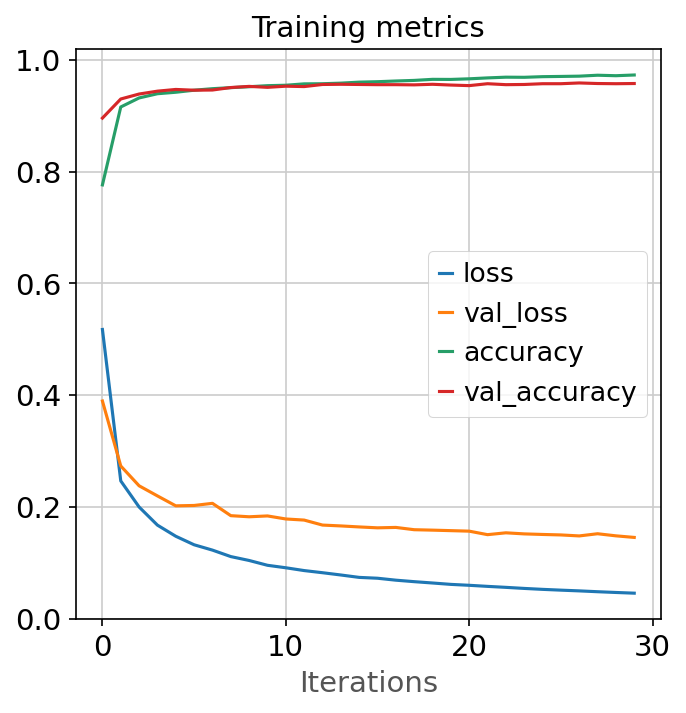

In [25]:
fig, axs = plt.subplots(figsize=(5,5))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training metrics')
plt.xlabel('Iterations')
plt.legend()

In [26]:
utils.print_metrics(model=model,
                  x_train=x_train_transformed,
                  y_train=y_train,
                  x_test=x_test_transformed,
                  y_test=y_test)

[INFO] Accuracy -- Train: 0.974, Test: 0.958
[INFO] ROC -- Train: 0.999, Test: 0.996


In [27]:
predictions = utils.make_predictions(model=model,
                     X_predict=X_predict_transformed,
                     encoder=encoder,
                     adata_predict=adata_predict,
                     probabilities=True,
                     save=False)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [28]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [29]:
accuracy_score(predictions['celltype'],predictions['STANN_predictions'])

0.8762970166737398

In [30]:
print(classification_report(predictions['celltype'],predictions['STANN_predictions']))

                          precision    recall  f1-score   support

              Astrocytes       0.92      0.85      0.89    108560
             Endothelial       0.97      0.71      0.82     85102
               Ependymal       0.78      0.79      0.79     20473
              Excitatory       0.85      0.80      0.82    143846
Immature oligodendrocyte       0.78      0.89      0.83     34723
              Inhibitory       0.87      0.93      0.90    324178
  Mature oligodendrocyte       0.91      0.99      0.95    126726
               Microglia       0.78      0.79      0.79     21165

                accuracy                           0.88    864773
               macro avg       0.86      0.84      0.85    864773
            weighted avg       0.88      0.88      0.87    864773



In [31]:
results = pd.DataFrame()

for Animal_ID in predictions.Animal_ID.unique():
    temp = predictions[predictions.Animal_ID==Animal_ID]
    for tissue_slice in temp.Bregma.unique():
        temp2 = temp[temp.Bregma==tissue_slice]
        acc = accuracy_score(temp2['celltype'],temp2['STANN_predictions'])
        
        results = results.append({'Animal_ID':Animal_ID,
                                  'Tissue_Slice':tissue_slice,
                                  'Accuracy':acc
                                 },ignore_index=True)

In [42]:
results.sort_values(by='Accuracy',ascending=False)[:50]

,Accuracy,Animal_ID,Tissue_Slice
16,0.917156,2.0,0.06
25,0.916344,3.0,0.21
36,0.913339,5.0,0.21
1,0.913301,1.0,0.21
87,0.912902,17.0,0.26
27,0.911302,3.0,0.11
63,0.911210,8.0,-0.24
2,0.910214,1.0,0.16
163,0.909943,26.0,0.26
153,0.909925,32.0,0.16


# Comparing results

In [33]:
adata_predict.obs['STANN_predictions'] = predictions['STANN_predictions']

#set spatial coordinates
adata_predict.obs['pixel_x'] = adata_predict.obs['Centroid_X']
adata_predict.obs['pixel_y'] = adata_predict.obs['Centroid_Y']
adata_predict.obsm["spatial"] = adata_predict.obs[['pixel_x','pixel_y']].to_numpy()

Trying to set attribute `.obs` of view, copying.


In [48]:
celltype_colors = {'Astrocytes': '#1f77b4',
 'Endothelial': '#ff7f0e',
 'Ependymal': '#279e68',
 'Excitatory': '#d62728',
 'Immature oligodendrocyte': '#aa40fc',
 'Inhibitory': '#8c564b',
 'Mature oligodendrocyte': '#e377c2',
 'Microglia': '#b5bd61'}

Trying to set attribute `.obs` of view, copying.
... storing 'Animal_sex' as categorical
... storing 'Behavior' as categorical
... storing 'Cell_class' as categorical
... storing 'Neuron_cluster_ID' as categorical


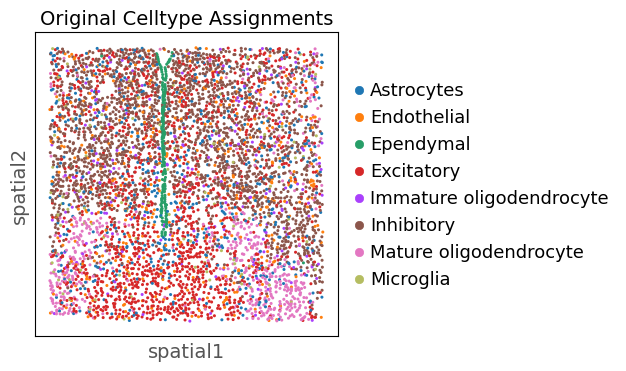

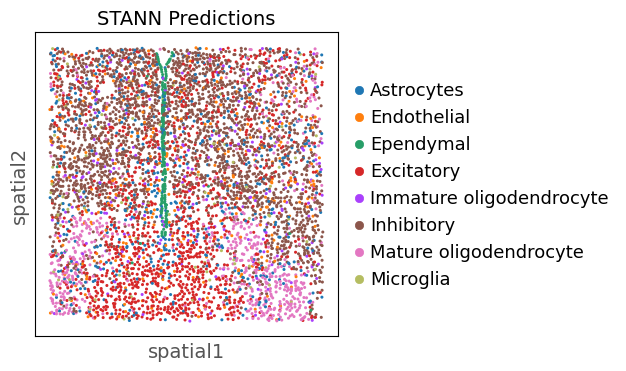

In [49]:

test = adata_predict[adata_predict.obs['Animal_ID'].isin([4.0]),:]
test = test[test.obs['Bregma'].isin([-0.29]),:]


transfer_palette_bulk = []
test.obs["celltype"] = test.obs["celltype"].astype('category')
for cell_class in list(test.obs["celltype"].cat.categories):
    transfer_palette_bulk.append(celltype_colors[cell_class])
test.uns['celltype_colors'] = transfer_palette_bulk

transfer_palette_bulk = []
test.obs["STANN_predictions"] = test.obs["STANN_predictions"].astype('category')
for cell_class in list(test.obs["STANN_predictions"].cat.categories):
    transfer_palette_bulk.append(celltype_colors[cell_class])
test.uns['STANN_predictions_colors'] = transfer_palette_bulk


sc.settings.set_figure_params(dpi=100)
sc.pl.spatial(test,
              color=["celltype"],
              #vmin=0, vmax=0.2,
              #color_map=plt.cm.YlOrRd,
              spot_size=20,
              title= ["Original Celltype Assignments"],
              save='Merfish_Original_Predictions'
              )

sc.settings.set_figure_params(dpi=100)
sc.pl.spatial(test,
              color=["STANN_predictions"],
              #vmin=0, vmax=0.2,
              #color_map=plt.cm.YlOrRd,
              spot_size=20,
              title= ["STANN Predictions"],
              save='Merfish_STANN_Predictions'
              )

In [38]:
predictions.to_csv('../outputs/STANN_predictions.csv')

In [57]:
test.obs.to_csv('../outputs/STANN_predictions_sample_slice.csv')